In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the Birmingham dataset
df = pd.read_csv("/content/drive/MyDrive/Computational intelligence/Birmingham_memorial_gradient_trees density.csv")


In [ ]:
# Create a graph from the dataset
G = nx.Graph()

# Add edges with attributes
for _, row in df.iterrows():
    # Extract coordinates from WKT to create node identifiers
    coords = row['wkt'].replace('LINESTRING(', '').replace(')', '').split(',')
    start_node = tuple(map(float, coords[0].strip().split()))
    end_node = tuple(map(float, coords[1].strip().split()))

    # Add edge with attributes
    G.add_edge(start_node, end_node,
               length_m=row['length_m'],
               meridian_class=row['meridian_class'],
               has_memorial=row['has_memorial'],
               trees_density=row['trees_density'],
               integration2km=row['integration2km'],
               gradient_class=row['gradient_class'])

# Feature encoding function
def encode_features(attr):
    # Road width mapping (meridian_class: 1=minor, 2=broad, 3=aroad)
    width_map = {1: 1, 2: 2, 3: 3}

    # Trees density - already numeric, just normalize
    trees_score = min(attr['trees_density'] * 10, 3)

    # Monument mapping
    binary_map = {"No": 0, "Yes": 1}

    # Syntax (integration) - normalize to 0-3 scale
    syntax_score = min(attr['integration2km'] / 50, 3)

    # Gradient class mapping
    gradient_str = str(attr['gradient_class'])
    if gradient_str == 'nan':
        gradient_score = 0
    elif '-' in gradient_str:
        upper_bound = float(gradient_str.split('-')[1].replace('%', ''))
        if upper_bound < 3:
            gradient_score = 2
        elif upper_bound < 5:
            gradient_score = 1
        elif upper_bound < 8:
            gradient_score = 0
        elif upper_bound < 10:
            gradient_score = -1
        else:
            gradient_score = -2
    else:
        gradient_score = 0

    return np.array([
        width_map.get(attr['meridian_class'], 1),
        trees_score,
        binary_map.get(attr['has_memorial'], 0),
        syntax_score,
        gradient_score
    ])

In [ ]:
from matplotlib.colors import Normalize
# Define weights for features
weights = np.array([0.2, 0.15, 0.1, 0.45, 0.1])

<ipython-input-4-c33b39289ec3>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


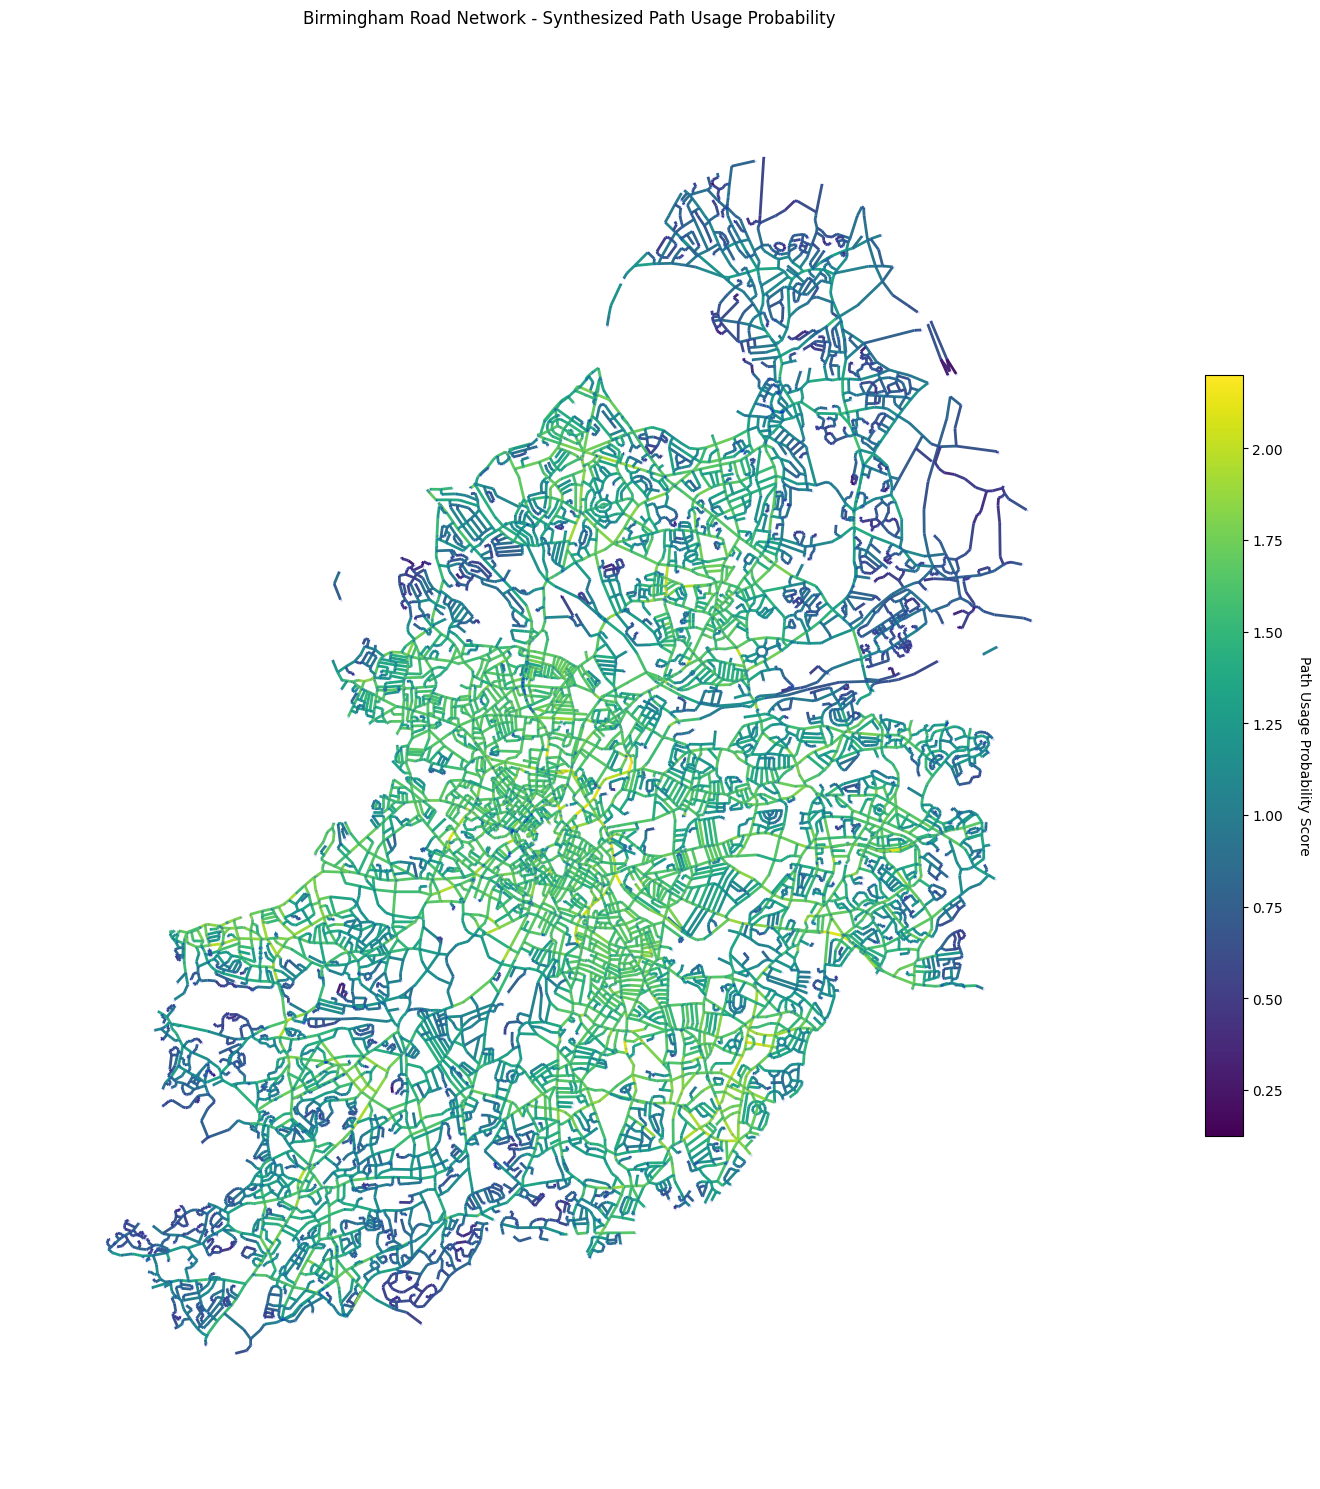

In [ ]:
# Calculate usage probability for each edge
edge_usage = {}
for u, v, data in G.edges(data=True):
    features = encode_features(data)
    score = np.dot(weights, features)
    edge_usage[(u, v)] = score

# Normalize scores to [0, 1] range for coloring
all_scores = list(edge_usage.values())
min_score, max_score = min(all_scores), max(all_scores)
norm = Normalize(vmin=min_score, vmax=max_score)
cmap = cm.get_cmap('viridis')

# Assign colors based on normalized scores
edge_colors = {}
for edge, score in edge_usage.items():
    normalized_score = norm(score)
    edge_colors[edge] = cmap(normalized_score)

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(20, 15))

# Get positions from node coordinates
pos = {node: (node[0], node[1]) for node in G.nodes()}

# Draw nodes (small and transparent to focus on edges)
nx.draw_networkx_nodes(G, pos, node_size=1, node_color='blue', alpha=0.1, ax=ax)

# Draw edges with their usage-based colors
edges = list(G.edges())
colors = [edge_colors[edge] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=2, ax=ax)


ax.set_aspect('equal')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Path Usage Probability Score', rotation=270, labelpad=20)

plt.title('Birmingham Road Network - Synthesized Path Usage Probability')
plt.axis('off')
plt.tight_layout()

**Checking Path Navigation**

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import random
from math import sqrt

# Load the Birmingham dataset
#df = pd.read_csv("/content/drive/MyDrive/Computational intelligence/Birmingham_memorial_gradient_trees density.csv")

# Create a graph from the dataset
G = nx.Graph()

# Add edges with attributes
for _, row in df.iterrows():
    coords = row['wkt'].replace('LINESTRING(', '').replace(')', '').split(',')
    start_node = tuple(map(float, coords[0].strip().split()))
    end_node = tuple(map(float, coords[1].strip().split()))

    G.add_edge(start_node, end_node,
               length_m=row['length_m'],
               meridian_class=row['meridian_class'],
               has_memorial=row['has_memorial'],
               trees_density=row['trees_density'],
               integration2km=row['integration2km'],
               gradient_class=row['gradient_class'])

# Feature encoding function (same as before)
def encode_features(attr):
    width_map = {1: 1, 2: 2, 3: 3}
    trees_score = min(attr['trees_density'] * 10, 3)
    binary_map = {"No": 0, "Yes": 1}
    syntax_score = min(attr['integration2km'] / 50, 3)

    gradient_str = str(attr['gradient_class'])
    if gradient_str == 'nan':
        gradient_score = 0
    elif '-' in gradient_str:
        upper_bound = float(gradient_str.split('-')[1].replace('%', ''))
        if upper_bound < 3:
            gradient_score = 2
        elif upper_bound < 5:
            gradient_score = 1
        elif upper_bound < 8:
            gradient_score = 0
        elif upper_bound < 10:
            gradient_score = -1
        else:
            gradient_score = -2
    else:
        gradient_score = 0

    return np.array([
        width_map.get(attr['meridian_class'], 1),
        trees_score,
        binary_map.get(attr['has_memorial'], 0),
        syntax_score,
        gradient_score
    ])

weights = np.array([0.2, 0.15, 0.1, 0.45, 0.1])

'\ntransition_probs = {}\nscores = []\n\n# Calculate usage probability for each edge\nfor u, v, data in G.edges(data=True):\n    features = encode_features(data)\n    score = np.dot(weights, features)\n    G.edges[u, v][\'usage_score\'] = score\n    scores.append(score)\n\n    # Normalize scores to probabilities\n    total_score = sum(scores)\n    if total_score > 0:\n        transition_probs[u] = {nbr: score / total_score for nbr, score in scores}\n    else:\n        transition_probs[u] = {nbr: 1 / len(scores) for nbr, _ in scores}  # uniform if zero score\n\n# Function to find suitable random nodes\ndef get_random_nodes(G, min_distance=0.1):\n    nodes = list(G.nodes())\n    while True:\n        start = random.choice(nodes)\n        end = random.choice(nodes)\n        if start != end:\n            # Calculate Euclidean distance between nodes\n            dx = start[0] - end[0]\n            dy = start[1] - end[1]\n            distance = sqrt(dx*dx + dy*dy)\n            if distance >= 

In [ ]:
# Step 4: Compute preference scores and transition probabilities
transition_probs = {}

for node in G.nodes:
    neighbors = list(G.neighbors(node))
    scores = []
    for neighbor in neighbors:
        features = encode_features(G[node][neighbor])
        score = np.dot(weights, features)
        scores.append((neighbor, score))

    # Normalize scores to probabilities
    total_score = sum(score for _, score in scores)
    if total_score > 0:
        transition_probs[node] = {nbr: score / total_score for nbr, score in scores}
    else:
        transition_probs[node] = {nbr: 1 / len(scores) for nbr, _ in scores}  # uniform if zero score

# Convert to DataFrame for display
transition_df = pd.DataFrame.from_dict(transition_probs, orient='index').fillna(0)
print("Transition Probabilities:")
print(transition_df)

Transition Probabilities:
                   399953.0  399963.0  399990.0  399984.0  400000.0 399848.0  \
                   281943.0  281857.0  281940.0  281923.0  281967.0 277354.0   
399984.0 281923.0  0.357292  0.359917  0.282791  0.000000  0.000000      0.0   
399990.0 281940.0  0.342255  0.000000  0.000000  0.269153  0.388592      0.0   
399959.0 281843.0  0.000000  0.336325  0.000000  0.000000  0.000000      0.0   
399912.0 281861.0  0.000000  0.525575  0.000000  0.000000  0.000000      0.0   
399953.0 281943.0  0.000000  0.000000  0.501608  0.498392  0.000000      0.0   
...                     ...       ...       ...       ...       ...      ...   
399329.0 284658.0  0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
399375.0 284683.0  0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
399634.0 283896.0  0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
399656.0 283881.0  0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
399169.0 28320

In [ ]:
# Function to find suitable random nodes
def get_random_nodes(G, min_distance=0.1):
    nodes = list(G.nodes())
    while True:
        start = random.choice(nodes)
        end = random.choice(nodes)
        if start != end:
            # Calculate Euclidean distance between nodes
            dx = start[0] - end[0]
            dy = start[1] - end[1]
            distance = sqrt(dx*dx + dy*dy)
            if distance >= min_distance:
                return start, end

# Get random start and end points
start_node, end_node = get_random_nodes(G)
print(f"Start node: {start_node}")
print(f"End node: {end_node}")
"""
Start node: (411938.0, 293814.0)
End node: (404414.0, 291946.0)
"""

Start node: (411938.0, 293814.0)
End node: (404414.0, 291946.0)


In [ ]:
#Reference points
start_node, end_node =(406735.0, 293502.0), (400961.0, 278580.0)

In [ ]:
# Step 5: Find the most likely path from A to E using log-probabilities (to convert product to sum)

def most_likely_path(transition_probs, start, goal):
    # Build log-probability graph
    G_log = nx.DiGraph()
    for u, neighbors in transition_probs.items():
        for v, prob in neighbors.items():
            if prob > 0:
                G_log.add_edge(u, v, weight=-np.log(prob))  # minimize negative log-probability

    try:
        path = nx.shortest_path(G_log, source=start, target=goal, weight='weight')
        prob = np.exp(-sum(G_log[u][v]['weight'] for u, v in zip(path[:-1], path[1:])))
        base, exponent = f"{prob:.2e}".split("e")
        formatted = f"{base} × 10^{int(exponent)}"
        return path, formatted
    except nx.NetworkXNoPath:
        return None, 0.0

most_likely_path_result = most_likely_path(transition_probs, start_node, end_node)
path, _ = most_likely_path_result
path_edges = list(zip(path[:-1], path[1:]))

<ipython-input-74-d4ecc8d4954c>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


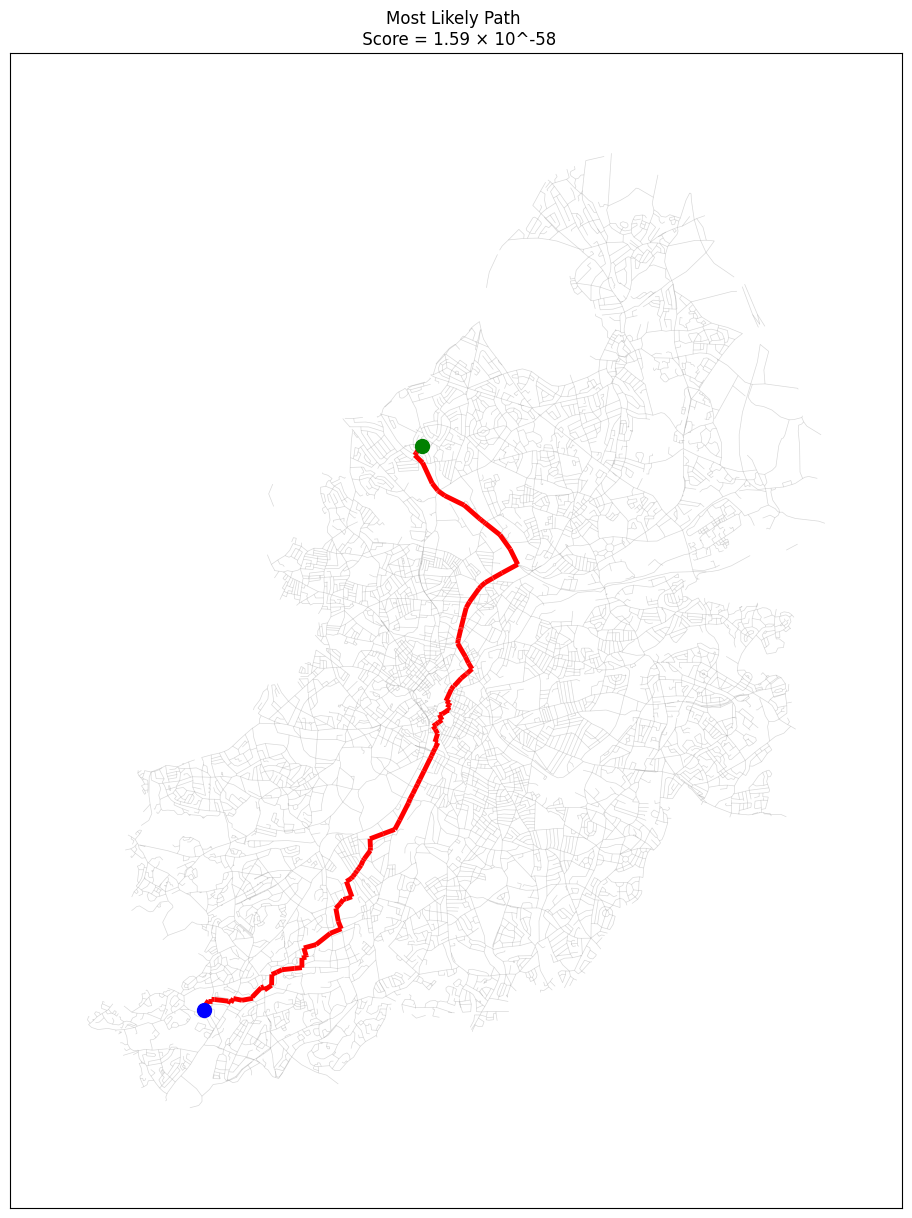

<Figure size 800x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Normalize scores for color mapping
scores = [np.dot(weights, encode_features(G[u][v])) for u, v in path_edges]
norm = plt.Normalize(min(scores), max(scores))
cmap = cm.get_cmap('viridis')

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(20, 15))

# Get positions from node coordinates
pos = {node: (node[0], node[1]) for node in G.nodes()}

# Draw base graph
plt.figure(figsize=(8, 6))
#nx.draw_networkx_nodes(G, pos, node_size=1, node_color='blue', alpha=0.1, ax=ax)

# Mark start and end points
nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green',
                          node_size=100, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color='blue',
                          node_size=100, ax=ax)

# Draw all edges in gray
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', width=0.5, alpha=0.3, ax=ax)
"""
# Draw path edges with viridis colors
for (u, v), score in zip(path_edges, scores):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=[cmap(norm(score))],
        width=3.5,
        ax=ax
    )
"""
# Draw path edges with red
for (u, v), score in zip(path_edges, scores):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color='red',
        width=3.5,
        ax=ax
    )

# Add title
ax.set_title(f"Most Likely Path \n Score = {most_likely_path_result[1]}", fontsize=12)

ax.set_aspect('equal')


In [ ]:
# Function to calculate angular change between edges
def calculate_angle(p1, p2, p3):

    #Calculate the angle between three points (in degrees)
    #p1 -> p2 -> p3

    # Create vectors
    v1 = (p1[0] - p2[0], p1[1] - p2[1])
    v2 = (p3[0] - p2[0], p3[1] - p2[1])

    # Calculate dot product and magnitudes
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    mag_v1 = sqrt(v1[0]**2 + v1[1]**2)
    mag_v2 = sqrt(v2[0]**2 + v2[1]**2)

    # Avoid division by zero
    if mag_v1 * mag_v2 == 0:
        return 0

    # Calculate angle in radians and convert to degrees
    angle_rad = np.arccos(dot_product / (mag_v1 * mag_v2))
    angle_deg = np.degrees(angle_rad)

    return angle_deg

# Function to find angular path (minimizing direction changes)
def find_angular_path(transition_probs, G, start, end):

    #Find path that minimizes angular changes using Dijkstra's algorithm

    # Create a new temporary graph for angular path calculation
    G_angular = G.copy()

    # Assign weights based on potential angular changes
    for u, v, data in G_angular.edges(data=True):
        data['angular_weight'] = 1  # Base weight

    # We'll use Dijkstra's algorithm with a custom weight function
    # that penalizes angular changes
    def angular_weight(u, v, data, path_so_far):
        if len(path_so_far) < 2:
            return data['angular_weight']

        # Get the previous two nodes in the path
        prev_node = path_so_far[-1]
        prev_prev_node = path_so_far[-2]

        # Calculate the angle between the previous edge and current edge
        angle = calculate_angle(prev_prev_node, prev_node, v)

        # Penalize based on the angle (more angle = higher penalty)
        return data['angular_weight'] + (angle / 180) * 10

    # For this example, we'll use the length with a small penalty for turns
    path = nx.shortest_path(G_angular, source=start, target=end, weight='length_m')

    log_prob_sum = sum(np.log(transition_probs[u][v]) for u, v in zip(path[:-1], path[1:]))
    prob = np.exp(log_prob_sum)
    base, exponent = f"{prob:.2e}".split("e")
    formatted = f"{base} × 10^{int(exponent)}"
    print(formatted)
    return path, formatted

ss_path = find_angular_path(transition_probs, G, start_node, end_node)
ss_path

sspath, _ = ss_path
sspath_edges = list(zip(sspath[:-1], sspath[1:]))


1.25 × 10^-69


<ipython-input-100-5cc2a32bdb06>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


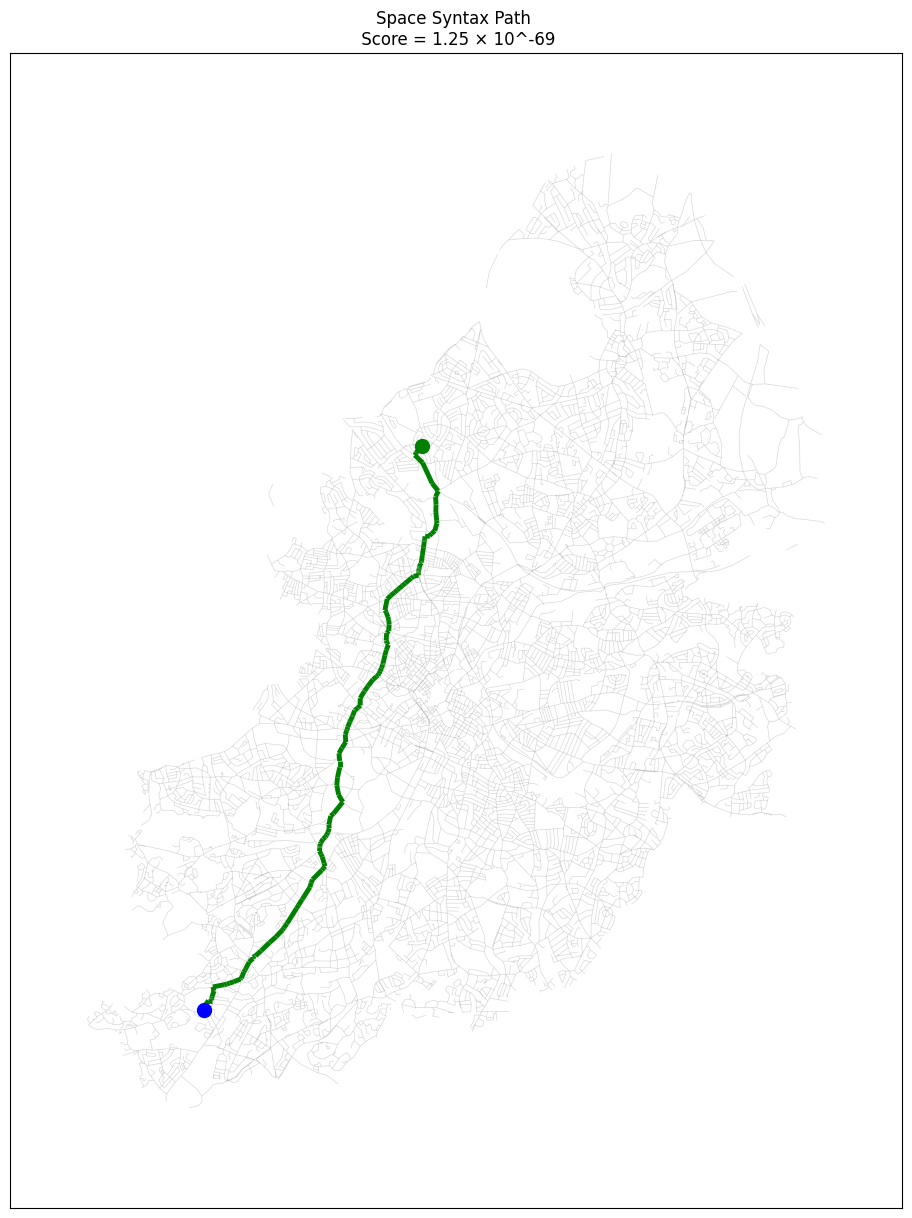

<Figure size 800x600 with 0 Axes>

In [ ]:
# Normalize scores for color mapping
scores = [np.dot(weights, encode_features(G[u][v])) for u, v in path_edges]
norm = plt.Normalize(min(scores), max(scores))
cmap = cm.get_cmap('viridis')

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(20, 15))

# Get positions from node coordinates
pos = {node: (node[0], node[1]) for node in G.nodes()}

# Draw base graph
plt.figure(figsize=(8, 6))
#nx.draw_networkx_nodes(G, pos, node_size=1, node_color='blue', alpha=0.1, ax=ax)

# Mark start and end points
nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green',
                          node_size=100, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color='blue',
                          node_size=100, ax=ax)

# Draw all edges in gray
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', width=0.5, alpha=0.3, ax=ax)
"""
# Draw path edges with viridis colors
for (u, v), score in zip(ss_path_edges, scores):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=[cmap(norm(score))],
        width=3.5,
        ax=ax
    )
"""
# Draw path edges with green
for (u, v) in sspath_edges:
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color='green',
        width=3.5,
        ax=ax
    )

# Add title
ax.set_title(f"Space Syntax Path \n Score = {ss_path[1]}", fontsize=12)

ax.set_aspect('equal')